In [111]:
import pickle

#load pickel file
with open('/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/images.pkl', 'rb') as f:
    data = pickle.load(f)
    

1.8799348523725257e-21 1.0


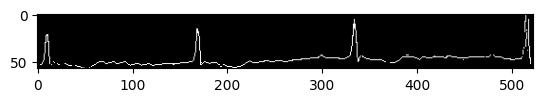

In [113]:
# print(data)
import matplotlib.pyplot as plt
import numpy as np

#plot the data
vis = np.where(data[9] > 0.5, 1, 0)
# plt.imshow(vis, cmap='gray')
plt.imshow(vis, cmap='gray')

print(min(data[1].flatten()), max(data[1].flatten()))

In [114]:
def compute_snr(x_ref, x_est, keep_nans=True, signal_median=False, noise_median=False):
    # Check the reference and estimated signals.
    x_ref = np.asarray(x_ref).copy()
    x_est = np.asarray(x_est).copy()
    assert(x_ref.ndim == x_est.ndim == 1)

    # Pad the shorter signal with NaNs so that both signals have the same length.
    n_ref = np.size(x_ref)
    n_est = np.size(x_est)
    if n_est < n_ref:
        x_est = np.concatenate((x_est, np.nan*np.ones(n_ref - n_est)))
    elif n_est > n_ref:
        x_ref = np.concatenate((x_ref, np.nan*np.ones(n_est - n_ref)))

    # Identify the samples with finite values, i.e., not NaN, +\infty, or -\infty.
    idx_ref = np.isfinite(x_ref)
    idx_est = np.isfinite(x_est) 

    # Either only consider samples with finite values in both signals (default) or replace the non-finite values in the estimated signal with zeros.
    if keep_nans:
        idx = np.logical_and(idx_ref, idx_est)
    else:
        x_est[~idx_est] = 0
        idx = idx_ref

    x_ref = x_ref[idx]
    x_est = x_est[idx]

    # Compute the noise.
    x_noise = x_ref - x_est

    # Compute the power for the signal and the noise using either the mean (default) or the median.
    if not signal_median:
        p_signal = np.mean(x_ref**2)
    else:
        p_signal = np.median(x_ref**2)

    if not noise_median:
        p_noise = np.mean(x_noise**2)
    else:
        p_noise = np.median(x_noise**2)

    # Compute the SNR.
    if p_signal > 0 and p_noise > 0:
        snr = 10 * np.log10(p_signal / p_noise)
    else:
        snr = float('nan')

    # If only considering the samples with finite values in both signals, then penalize the samples with non-finite values in the
    # estimated signal but not in the reference signal.
    if keep_nans:
        alpha = np.sum(idx) / np.sum(idx_ref)
        snr *= alpha

    return snr, p_signal, p_noise

In [29]:
from helper_code import *
import warnings

In [53]:
## helper functions
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

# def interpolate_nan(signal):
#     if np.isnan(signal[0]):
#         signal[0] = 0
#     if np.isnan(signal[-1]):
#         signal[-1] = 0
#     nans, x = nan_helper(signal)
#     if len(nans) == 0:
#         return signal
#     signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])
#     return signal

from scipy.interpolate import CubicSpline

def interpolate_nan(signal):
    nans, x = np.isnan(signal), lambda z: z.nonzero()[0]
    if np.isnan(signal).all():
        warnings.warn("Signal is all nan", UserWarning)
        return np.zeros_like(signal)
    signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])
    # For sharper interpolation:
    cs = CubicSpline(np.arange(len(signal)), signal, bc_type='natural')
    return cs(np.arange(len(signal)))

from scipy.signal import resample

def upsample(signal, target_length):
    return resample(signal, target_length)

def downsample(signal, target_length):
    return resample(signal, target_length)


def filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks):
    def bbox_iou(box1, box2):
        inter_rect_x1 = max(box1[0], box2[0])
        inter_rect_y1 = max(box1[1], box2[1])
        inter_rect_x2 = min(box1[2], box2[2])
        inter_rect_y2 = min(box1[3], box2[3])

        inter_area = max(0, inter_rect_x2 - inter_rect_x1 + 1) * max(0, inter_rect_y2 - inter_rect_y1 + 1)

        b1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        b2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

        return inter_area / (b1_area + b2_area - inter_area)
    
    if len(pred_bboxes) > 13:
        keep = np.ones(len(pred_bboxes), dtype=bool)
        for i in range(len(pred_bboxes)):
            for j in range(i + 1, len(pred_bboxes)):
                if keep[j] and bbox_iou(pred_bboxes[i], pred_bboxes[j]) > 0.3:
                    keep[j] = pred_scores[i] > pred_scores[j]

        pred_bboxes = pred_bboxes[keep]
        pred_labels = pred_labels[keep]
        pred_masks = pred_masks[keep]
        pred_scores = pred_scores[keep]

    # Ensure there are exactly 13 bboxes
    if len(pred_bboxes) > 13:
        # Sort by scores in descending order
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_bboxes = pred_bboxes[sorted_indices][:13]
        pred_labels = pred_labels[sorted_indices][:13]
        pred_masks = pred_masks[sorted_indices][:13]
        pred_scores = pred_scores[sorted_indices][:13]
    # elif len(pred_bboxes) < 12:
    #     # Pad the remaining slots with the highest scoring bboxes
    #     top_indices = np.argsort(pred_scores)[::-1]
    #     while len(pred_bboxes) < 13:
    #         for idx in top_indices:
    #             if len(pred_bboxes) < 13:
    #                 pred_bboxes = np.append(pred_bboxes, [pred_bboxes[idx]], axis=0)
    #                 pred_labels = np.append(pred_labels, [pred_labels[idx]], axis=0)
    #                 pred_masks = np.append(pred_masks, [pred_masks[idx]], axis=0)
    #                 pred_scores = np.append(pred_scores, [pred_scores[idx]], axis=0)
    #             else:
    #                 break
    
    
    if len(pred_bboxes) != 13:
        warnings.warn(f"Expected 13 boxes, got {len(pred_bboxes)}", UserWarning)
    
    return pred_bboxes, pred_labels, pred_scores, pred_masks

from scipy.signal import savgol_filter

def apply_savgol_filter(signal):
    return savgol_filter(signal, window_length=5, polyorder=3)  # Adjust parameters as needed

from sklearn.cluster import KMeans

def bboxes_sorting_less_than_12_sorted(bboxes, masks):
    # Calculate the average x and y coordinates for each bbox
    bboxes_avg = np.column_stack(((bboxes[:, 0] + bboxes[:, 2]) / 2, (bboxes[:, 1] + bboxes[:, 3]) / 2))
    
    # Perform KMeans clustering to identify rows and columns
    kmeans_rows = KMeans(n_clusters=3, random_state=0).fit(bboxes_avg[:, 1].reshape(-1, 1))
    kmeans_cols = KMeans(n_clusters=4, random_state=0).fit(bboxes_avg[:, 0].reshape(-1, 1))
    
    # Get the cluster centers
    row_centers = np.sort(kmeans_rows.cluster_centers_.flatten())
    col_centers = np.sort(kmeans_cols.cluster_centers_.flatten())
    
    # Create an empty grid to hold bbox indices
    grid = np.full((3, 4), -1)
    
    # Assign bboxes to the grid based on their cluster labels
    for i in range(len(bboxes)):
        row = np.argmin(np.abs(row_centers - bboxes_avg[i, 1]))
        col = np.argmin(np.abs(col_centers - bboxes_avg[i, 0]))
        grid[row, col] = i
    
    # Identify missing positions in the grid
    missing_bboxes = []
    missing_masks = []
    for i in range(3):
        for j in range(4):
            if grid[i, j] == -1:
                # Estimate missing bbox by average location (center of the missing cell)
                avg_y = row_centers[i]
                avg_x = col_centers[j]
                # Estimate bbox as a small box centered at the estimated position
                estimated_bbox = [avg_x - 1, avg_y - 1, avg_x + 1, avg_y + 1]
                missing_bboxes.append(estimated_bbox)
                missing_masks.append(np.zeros_like(masks[0]))
    
    # Add missing bboxes and masks to the existing ones
    if missing_bboxes:
        bboxes = np.vstack([bboxes, missing_bboxes])
        masks = np.vstack([masks, missing_masks])
    
    # Recompute the averages with the added bounding boxes
    bboxes_avg = np.column_stack(((bboxes[:, 0] + bboxes[:, 2]) / 2, (bboxes[:, 1] + bboxes[:, 3]) / 2))
    
    # Reassign the bboxes to rows and columns after filling in the missing ones
    sorted_indices = []
    for i in range(3):
        for j in range(4):
            row = np.argmin(np.abs(row_centers[i] - bboxes_avg[:, 1]))
            col = np.argmin(np.abs(col_centers[j] - bboxes_avg[:, 0]))
            idx = np.intersect1d(np.where(np.abs(bboxes_avg[:, 1] - row_centers[i]) < 1e-5),
                                 np.where(np.abs(bboxes_avg[:, 0] - col_centers[j]) < 1e-5))
            if len(idx) > 0:
                sorted_indices.append(idx[0])
    
    bboxes_sorted = bboxes[sorted_indices]
    masks_sorted = masks[sorted_indices]
    
    return bboxes_sorted, masks_sorted
    
    

def bboxes_sorting_12(bboxes, masks):
    # Compute the average height and width directly using numpy for efficiency
    bboxes_avg = (bboxes[:, [1, 3]].mean(axis=1), bboxes[:, [0, 2]].mean(axis=1))
    bboxes_avg = np.array(bboxes_avg).T
    
    # Sort by the average width
    sortW_idx = np.argsort(bboxes_avg[:, 1])
    bboxes_avg = bboxes_avg[sortW_idx]
    masks = masks[sortW_idx]
    bboxes = bboxes[sortW_idx]
    
    # Sort columns by the average height
    idx = np.hstack([
        np.argsort(bboxes_avg[0:3, 0]),
        np.argsort(bboxes_avg[3:6, 0]) + 3,
        np.argsort(bboxes_avg[6:9, 0]) + 6,
        np.argsort(bboxes_avg[9:12, 0]) + 9
    ])
    
    masks = masks[idx]
    bboxes = bboxes[idx]
    
    # Calculate row boundaries and lead width
    rowl = np.median(bboxes[0:3, 0])
    rowr = np.median(bboxes[9:12, 2])
    leadwidth = (rowr - rowl) / 4
    
    # Assign values row by row
    for i in range(0, 12, 3):
        bboxes[i:i+3, 0] = rowl + leadwidth * (i // 3)
        bboxes[i:i+3, 2] = rowl + leadwidth * (i // 3 + 1)
    
    bboxes[9:12, 2] = rowr  # Final column adjustment
    
    return bboxes, masks




def bboxes_sorting_13(bboxes, masks):
    # Compute the average height and width directly using numpy for efficiency
    bboxes_avg = (bboxes[:, [1, 3]].mean(axis=1), bboxes[:, [0, 2]].mean(axis=1))
    bboxes_avg = np.array(bboxes_avg).T
    
    # Sort by the average height
    sortH_idx = np.argsort(bboxes_avg[:, 0])
    
    # Separate the last item
    mask_last = masks[sortH_idx[12]]
    bbox_last = bboxes[sortH_idx[12]]
    
    # Keep only the first 12 items
    bboxes_avg = bboxes_avg[sortH_idx[:12]]
    masks = masks[sortH_idx[:12]]
    bboxes = bboxes[sortH_idx[:12]]
    
    # Sort by the average width
    sortW_idx = np.argsort(bboxes_avg[:, 1])
    bboxes_avg = bboxes_avg[sortW_idx]
    masks = masks[sortW_idx]
    bboxes = bboxes[sortW_idx]
    
    # Sort columns by the average height
    idx = np.hstack([
        np.argsort(bboxes_avg[0:3, 0]),
        np.argsort(bboxes_avg[3:6, 0]) + 3,
        np.argsort(bboxes_avg[6:9, 0]) + 6,
        np.argsort(bboxes_avg[9:12, 0]) + 9
    ])
    
    masks = masks[idx]
    bboxes = bboxes[idx]
    
    # Insert the last bbox and mask
    bboxes[1] = bbox_last
    masks[1] = mask_last
    
    # Calculate row boundaries and lead width
    rowl = np.median(bboxes[0:3, 0])
    rowr = np.median(bboxes[9:12, 2])
    leadwidth = (rowr - rowl) / 4
    
    # Assign values row by row
    for i in range(0, 12, 3):
        bboxes[i:i+3, 0] = rowl + leadwidth * (i // 3)
        bboxes[i:i+3, 2] = rowl + leadwidth * (i // 3 + 1)
    
    bboxes[9:12, 2] = rowr  # Final column adjustment
    
    # Special case for the inserted last bbox
    if bboxes[1, 2] < rowr:
        bboxes[1, 2] = rowr
    
    return bboxes, masks



## helper functions end 

#format = [['I', 'aVR', 'V1', 'V4'], ['II', 'aVL', 'V2', 'V5'], ['III', 'aVF', 'V3', 'V6'], ['II']] # format is hardcoded for now
#format = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']
#fullmode = 'II'

def crop_from_bbox(bbox, mask, mV_pixel):
    bbox = bbox.astype(int)
    ecg_segment = mask[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]

    weighting_matrix = np.linspace((bbox[3] - bbox[1])*mV_pixel/2, -1*(bbox[3] - bbox[1])*mV_pixel/2, num=ecg_segment.shape[0]).reshape(-1, 1)
    weighted_ecg_segment = ecg_segment * weighting_matrix

    denominator = np.sum(ecg_segment, axis=0)
    numerator = np.sum(weighted_ecg_segment, axis=0)

    signal = np.full(denominator.shape, np.nan)
    valid_idx = denominator >= 1
    signal[valid_idx] = numerator[valid_idx] / denominator[valid_idx]
    # check if signal is all nan
    if np.isnan(signal).all():
        warnings.warn("Signal is all nan", UserWarning)

    return signal

# median method
# def crop_from_bbox(bbox, mask, mV_pixel):
#     bbox = bbox.astype(int)
#     ecg_segment = mask[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]

#     height = ecg_segment.shape[0]

#     a = -1*mV_pixel*height/(height-1)
#     b = mV_pixel*height/2
#     signal = [a*np.median(np.argwhere(ecg_segment[:,i]))+b if len(np.argwhere(ecg_segment[:,i]))>1 else np.nan  for i in range(ecg_segment.shape[1])]
#     signal = np.array(signal)
#     return signal


def readOut(header_path, masks, bboxes, mV_pixel):

    
    with open(header_path, 'r') as f:
        input_header = f.read()

    num_samples = get_num_samples(input_header)

    # case 1: less than 12 boxes, return empty signals
    # assert bboxes.shape[0] == masks.shape[0], f"Expected shape {bboxes.shape[0]}, got {masks.shape[0]}"
    if bboxes.shape[0] < 12:
        # failed to detect 12 leads
        empty_signals_np = np.full((12, num_samples), np.nan)
        lead_length = num_samples // 4
        empty_signals_np[0:3,0:lead_length] = 0
        empty_signals_np[3:6,lead_length:2*lead_length] = 0
        empty_signals_np[6:9,2*lead_length:3*lead_length] = 0
        empty_signals_np[9:12,3*lead_length:4*lead_length] = 0
        return empty_signals_np.T if empty_signals_np.shape[1] > empty_signals_np.shape[0] else empty_signals_np
        
    # case 2: 12 bboxes, filter boxes
    if bboxes.shape[0] == 12:
        bboxes, masks = bboxes_sorting_12(bboxes, masks)
        signals_np = np.full((12, num_samples), np.nan)
        for i in range(bboxes.shape[0]):
            signal = crop_from_bbox(bboxes[i], masks[i], mV_pixel)
            signal = interpolate_nan(signal) - np.mean(signal)
            signal = np.clip(signal, -2, 2)
            signallen = num_samples // 4
            # signal = apply_savgol_filter(signal)
            signal = upsample(signal, signallen) if len(signal) < signallen else downsample(signal, signallen)
            start_idx = (num_samples // 4) * (i // 3)
            end_idx = start_idx + (num_samples // 4)
            signals_np[i, start_idx:end_idx] = signal
        signals_np = np.clip(signals_np, -2, 2)
        return signals_np.T if signals_np.shape[1] > signals_np.shape[0] else signals_np



    # case 3: at least 13 bboxes
    if bboxes.shape[0] >= 13:
        bboxes, masks = bboxes_sorting_13(bboxes, masks)
        signals_np = np.full((12, num_samples), np.nan)

        for i in range(12):
            signal = crop_from_bbox(bboxes[i], masks[i], mV_pixel)   
            signal = interpolate_nan(signal) - np.mean(signal)
            signal = np.clip(signal, -2, 2)
            signallen = num_samples if i == 1 else num_samples // 4
            # signal = apply_savgol_filter(signal)
            signal = upsample(signal, signallen) if len(signal) < signallen else downsample(signal, signallen)
            
            if i == 1:
                signals_np[i] = signal
            else:
                start_idx = (num_samples // 4) * (i // 3)
                end_idx = start_idx + (num_samples // 4)
                signals_np[i, start_idx:end_idx] = signal

        return signals_np.T if signals_np.shape[1] > signals_np.shape[0] else signals_np

In [75]:
from helper_code import align_signals
# Set limits on how far the signal can be shifted, and the number of quantization levels when shifting the signals.
def shift_signals(signal_ref, signal_est, sampling_frequency, channels, no_shift=False):
    max_hz_shift = np.round(0.5*sampling_frequency)
    max_vt_shift = 1.0
    num_quant_levels = 2**8

    # Shift the digitied signals to better align with the reference signals.
    signal_ref_collection = list()
    signal_est_collection = list()
    for j, channel in enumerate(channels):
        signal_ref_collection.append(signal_ref[:, j])
        # Align the signals.
        if not no_shift:
            signal_shifted, shift_hz, shift_vt = align_signals(signal_ref[:, j], signal_est[:, j], num_quant_levels=num_quant_levels)
            if abs(shift_hz) <= max_hz_shift and abs(shift_vt) <= max_vt_shift:
                signal_est_collection.append(signal_shifted)
            else:
                signal_est_collection.append(signal_est[:, j])
        else:
            signal_est_collection.append(signal_est[:, j])

TeamCode/tests/resources/test_data/00010_lr
SNR for lead I: 3.9790660161465405
SNR for lead avr: 0.827273915371214
SNR for lead v1: 2.416487669762237
SNR for lead v4: -1.4475533701547538
SNR for lead II: 5.448075305919266
SNR for lead avl: 9.096994845752649
SNR for lead v2: 3.2319457930322866
SNR for lead v5: -2.5309311641343513
SNR for lead III: 6.662532809867444
SNR for lead avf: -0.13621267269218984
SNR for lead v3: 3.4328185238174234
SNR for lead v6: -0.47555981823780447
SNR: 2.542078154537497


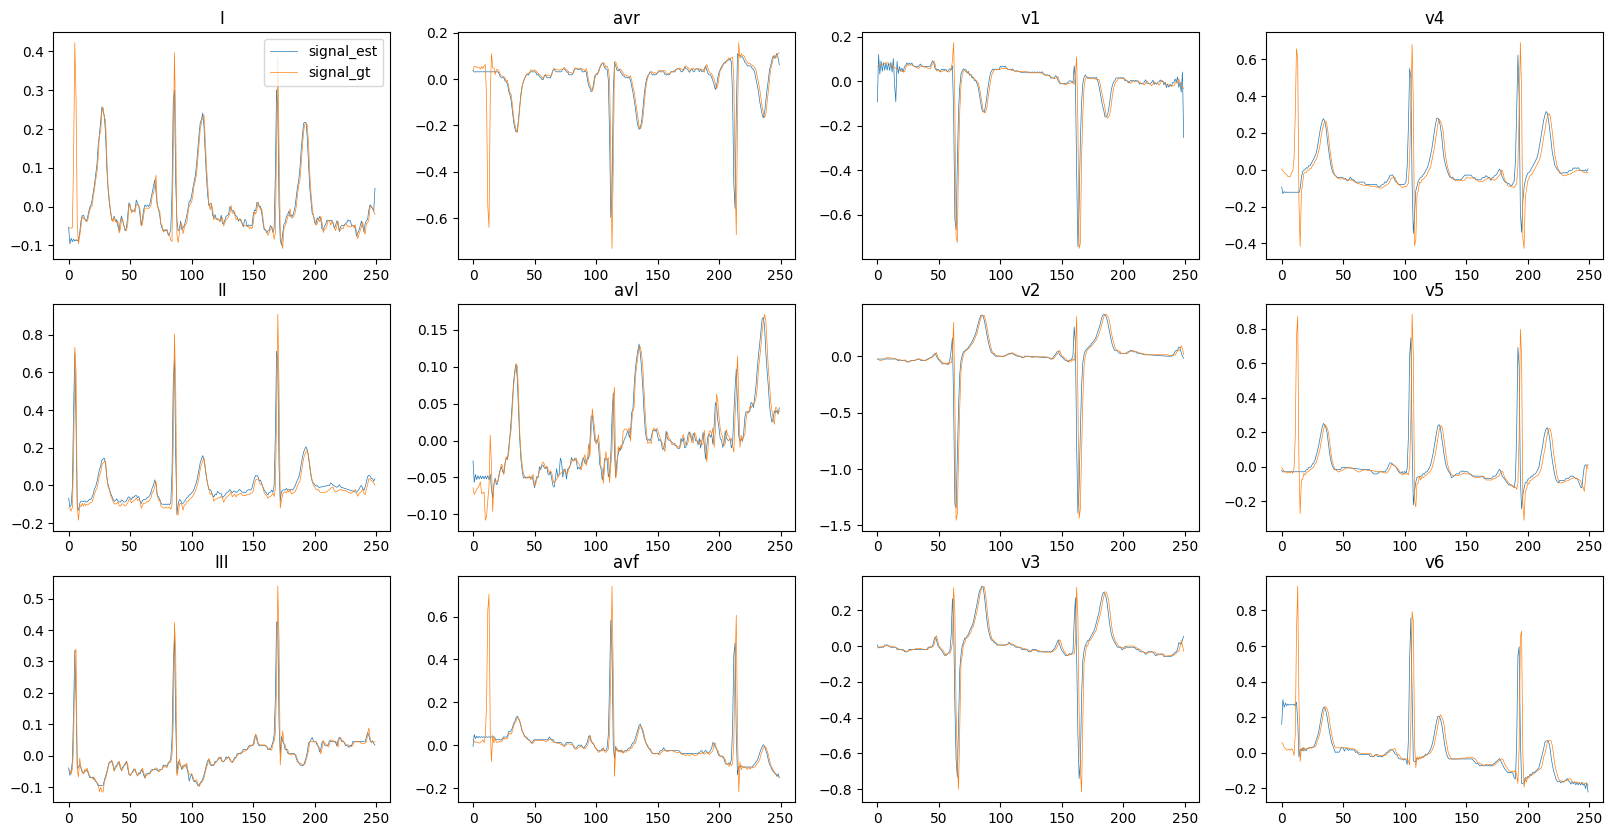

In [116]:
from helper_code import get_num_samples, load_signals
from scipy import interpolate
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import pickle

    

record = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_data/00010_lr'
pkl_pth = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/to_dump.pkl'
header_pth = record+'.hea'
with open(header_pth, 'r') as f:
    input_header = f.read()
num_samples = get_num_samples(input_header)

signal_gt = load_signals(record)[0]

pkl = pickle.load(open(pkl_pth, 'rb'))
masks = pkl['masks']#.detach().numpy()
bboxes = pkl['bboxes']#.detach().numpy()
scores = pkl['scores']#.detach().numpy()
labels = pkl['labels']#.detach().numpy()
record = pkl['record']
# signal_gt = load_signals(record)[0]
print(record)
# bboxes, labels, scores, masks = filter_boxes(bboxes, labels, scores, masks)
# plt.imshow(masks[0]*255, cmap='gray')
# print(np.sum(masks[0]))



#format = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']
mV_pixel = (25.4 *8.5*0.5)/(masks[0].shape[0]*5) 

signal_est = readOut(header_pth, masks, bboxes, mV_pixel)


# snr = compute_snr(signal_gt.flatten(), signal_est.flatten())
snrs = []
snr = compute_snr(signal_est[0:num_samples//4,0], signal_gt[0:num_samples//4,0])
snrs.append(snr[0])
print(f"SNR for lead I: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,3], signal_gt[num_samples//4:(num_samples//4)*2,3])
snrs.append(snr[0])
print(f"SNR for lead avr: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,6], signal_gt[(num_samples//4)*2:(num_samples//4)*3,6])
snrs.append(snr[0])
print(f"SNR for lead v1: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,9], signal_gt[(num_samples//4)*3:num_samples,9])
snrs.append(snr[0])
print(f"SNR for lead v4: {snr[0]}")

snr = compute_snr(signal_est[0:num_samples//4,1], signal_gt[0:num_samples//4,1])
snrs.append(snr[0])
print(f"SNR for lead II: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,4], signal_gt[num_samples//4:(num_samples//4)*2,4])
snrs.append(snr[0])
print(f"SNR for lead avl: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,7], signal_gt[(num_samples//4)*2:(num_samples//4)*3,7])
snrs.append(snr[0])
print(f"SNR for lead v2: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,10], signal_gt[(num_samples//4)*3:num_samples,10])
snrs.append(snr[0])
print(f"SNR for lead v5: {snr[0]}")

snr = compute_snr(signal_est[0:num_samples//4,2], signal_gt[0:num_samples//4,2])
snrs.append(snr[0])
print(f"SNR for lead III: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,5], signal_gt[num_samples//4:(num_samples//4)*2,5])
snrs.append(snr[0])
print(f"SNR for lead avf: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,8], signal_gt[(num_samples//4)*2:(num_samples//4)*3,8])
snrs.append(snr[0])
print(f"SNR for lead v3: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,11], signal_gt[(num_samples//4)*3:num_samples,11])
snrs.append(snr[0])
print(f"SNR for lead v6: {snr[0]}")



print('SNR:', np.nanmean(snrs))
linewidth = 0.5
plt.figure(figsize=(20,10))
plt.subplot(3,4,1), plt.plot(signal_est[0:num_samples//4,0], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,0], label='signal_gt',linewidth=linewidth), plt.title('I'), plt.legend()
plt.subplot(3,4,5), plt.plot(signal_est[0:num_samples//4,1], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,1], label='signal_gt', linewidth=linewidth), plt.title('II')
plt.subplot(3,4,9), plt.plot(signal_est[0:num_samples//4,2], label = 'signal_est',linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,2], label='signal_gt',linewidth=linewidth), plt.title('III')

plt.subplot(3,4,2), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,3], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,3], label='signal_gt', linewidth=linewidth), plt.title('avr')
plt.subplot(3,4,6), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,4], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,4], label='signal_gt', linewidth=linewidth), plt.title('avl')
plt.subplot(3,4,10), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,5], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,5], label='signal_gt', linewidth=linewidth), plt.title('avf')

plt.subplot(3,4,3), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,6], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,6], label='signal_gt', linewidth=linewidth), plt.title('v1')
plt.subplot(3,4,7), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,7], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,7], label='signal_gt', linewidth=linewidth), plt.title('v2')
plt.subplot(3,4,11), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,8], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,8], label='signal_gt', linewidth=linewidth), plt.title('v3')


plt.subplot(3,4,4), plt.plot(signal_est[(num_samples//4)*3:num_samples,9], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,9], label='signal_gt', linewidth=linewidth), plt.title('v4')
plt.subplot(3,4,8), plt.plot(signal_est[(num_samples//4)*3:num_samples,10], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,10], label='signal_gt', linewidth=linewidth), plt.title('v5')
plt.subplot(3,4,12), plt.plot(signal_est[(num_samples//4)*3:num_samples,11], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,11], label='signal_gt', linewidth=linewidth), plt.title('v6')

plt.show()
# plt.savefig('test.png')
plt.close()

Loads checkpoint by local backend from path: /scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/model/epoch_12.pth
12
12


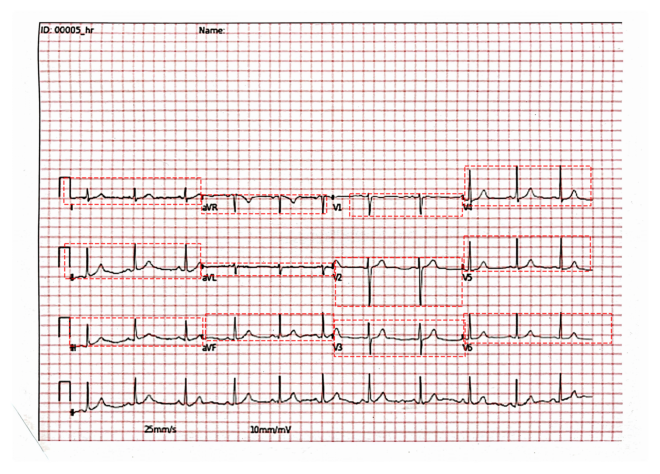

In [110]:

import mmcv
from mmdet.apis import init_detector, inference_detector
import os
import cv2
def remove_image_gradients(image_array):
   # Step 2: Split the image into R, G, B channels
    if image_array.shape[2] == 4:
        b_channel, g_channel, r_channel, a_channel = cv2.split(image_array)
    elif image_array.shape[2] == 3:
        b_channel, g_channel, r_channel = cv2.split(image_array)
        a_channel = np.ones_like(b_channel) * 255
    else: return image_array

    # Step 3: Apply Laplacian filter to each channel
    laplacian_b = cv2.Laplacian(b_channel, cv2.CV_64F)
    laplacian_g = cv2.Laplacian(g_channel, cv2.CV_64F)
    laplacian_r = cv2.Laplacian(r_channel, cv2.CV_64F)

    # Convert the result back to uint8 (8-bit image) because Laplacian can result in negative values
    laplacian_b = cv2.convertScaleAbs(laplacian_b)
    laplacian_g = cv2.convertScaleAbs(laplacian_g)
    laplacian_r = cv2.convertScaleAbs(laplacian_r)

    # Step 4: Merge the channels back together
    laplacian_rgb = cv2.merge((laplacian_b, laplacian_g, laplacian_r))
    return laplacian_rgb
# model_name = "mask_combo_loss_higher_res2"
model_name = "maskrcnn_res101"
# model_name = "deform_detr"
work_dir = f'/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/model/'
# config=os.path.join(work_dir, f'mask-rcnn_r50-caffe_fpn_ms-poly-3x_ecg.py')
config = os.path.join(work_dir, f'{model_name}.py')

# img_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_scan'
# img_dir = os.path.join(img_dir, '00005_hr-0.png')
img_dir = '/scratch/hshang/moody/ecg-image-kit/sample-data/ecg-images/ecg00001.png'
# img_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_data/00003_lr-0.png'
img = mmcv.imread(img_dir,channel_order='rgb')
checkpoint_file = os.path.join(work_dir, 'epoch_12.pth')
model = init_detector(config, checkpoint_file, device='cpu')
processed_img = remove_image_gradients(img)
new_result = inference_detector(model, processed_img)
# print(new_result)

from mmengine.visualization import Visualizer
import torch
import numpy as np
## extract boxes, masks, scores, and lables :
pred_bboxes = new_result.pred_instances.bboxes
pred_labels = new_result.pred_instances.labels
pred_scores = new_result.pred_instances.scores
print(len(pred_bboxes))
# pred_masks = new_result.pred_instances.masks
#check if pred_masks is all false
# print(np.all(pred_masks.cpu().numpy() == False))
pred_bboxes = pred_bboxes.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_scores = pred_scores.cpu().numpy()
# pred_masks = pred_masks.cpu().numpy()
pred_masks = np.zeros((pred_bboxes.shape[0], img.shape[0], img.shape[1]))


def filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks):
    """
    Filter out the boxes with low confidence score and remove the boxes with high IoU
    Args:
        pred_bboxes (np): list of bounding boxes
        pred_labels (np): list of labels
        pred_scores (np): list of confidence scores
        pred_masks (np): list of masks
    Returns:
        np: filtered bounding boxes
        np: filtered labels
        np: filtered confidence scores
        np: filtered masks
    """
    def bbox_intersection_over_smaller_area(box1, box2):
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # boxes Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)
        
        return inter_area / min(b1_area, b2_area)
    def bbox_iou(box1, box2):
        """
        Calculate the Intersection of Unions (IoUs) between bounding boxes.
        Args:
            box1 (list): bounding box formatted as [x1, y1, x2, y2]
            box2 (list): bounding box formatted as [x1, y1, x2, y2]
        Returns:
            float: IoU value
        """
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # Union Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

        iou = inter_area / (b1_area + b2_area - inter_area)

        return iou
    # # loop over bounding boxes, if find some boxes have iou > 0.5, filter out the one with lower score

    if len(pred_bboxes) > 13:
        for i in range(len(pred_bboxes)):
            for j in range(i+1, len(pred_bboxes)):
                iou = bbox_intersection_over_smaller_area(pred_bboxes[i], pred_bboxes[j])
                if iou > 0.3:
                    if pred_scores[i] > pred_scores[j]:
                        pred_scores[j] = 0
                    else:
                        pred_scores[i] = 0
        pred_bboxes = pred_bboxes[pred_scores > 0]
        pred_labels = pred_labels[pred_scores > 0]
        pred_masks = pred_masks[pred_scores > 0]
        pred_scores = pred_scores[pred_scores > 0]
    
    if len(pred_scores) > 13:
        # sort the scores and get the top 13
        indices = np.argsort(pred_scores)[::-1][:13]
        pred_bboxes = pred_bboxes[indices]
        pred_labels = pred_labels[indices]
        pred_masks = pred_masks[indices]
        pred_scores = pred_scores[indices]
    
    return pred_bboxes, pred_labels, pred_scores, pred_masks

filtered_bboxes, filtered_labels, filtered_scores, filtered_masks = filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks)




# pred_image = mmcv.imread(img_dir, channel_order='rgb')
visualizer = Visualizer(image=img)

# draw multiple bboxes
# single bbox formatted as [xyxy]
print(len(filtered_bboxes))
visualizer.draw_bboxes(filtered_bboxes, edge_colors='r',
                       line_widths=3, line_styles = '--')

# visualizer.draw_texts(pred_scores.cpu().numpy(), pred_bboxes)
## to draw a box formatted as [xyxy]
# visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]))

# visualizer.draw_binary_masks(new_result.pred_instances.masks) ## this also works
# visualizer.draw_binary_masks(filtered_masks, colors=(0, 0, 255), alphas=0.9)

visualizer.show()

In [38]:
print(np.sum(masks[0]))

1160
